In [1]:
import numpy as np
import wormholes as wh
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.tri import Triangulation
from scipy.optimize import curve_fit
from tqdm import tqdm
from itertools import product
import colorcet as cc

In [2]:
# Suppress warnings
# (Many overflows/underflows otherwise, since exp(u,v,φ) appear throughout)
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{amssymb} \\usepackage{amsmath}'

# Massive type IIA on $S^3\times S^3$

A consistent truncation of massive type IIA SUGRA on $S^3\times S^3$ is described by the following 4D action:

$$ \begin{align*}
    S_4 &= \frac{1}{2\kappa_4^2}\int\Big( {\star R} - \frac{1}{2}\mathrm{d}\phi\wedge{\star\mathrm{d}\phi} - 6\,\mathrm{d}u\wedge{\star\mathrm{d}u} + \frac{1}{2}e^{-3u+\phi/2}\mathrm{d}\chi\wedge{\star\mathrm{d}\chi} - {\star\mathcal{V}} \Big) \,,\\
    \mathcal{V} &= -12e^{-4u} + 5e^{-9u-\phi/2} + e^{-3u+5\phi/2} \,.
\end{align*} $$

By design, the minimum of $\mathcal{V}$ is at $u=\phi=0$. The $\chi$ equation of motion can be solved in terms of a flux $\mathfrak{f}$ as $e^{-3u+\phi/2}\mathrm{d}\chi = \mathfrak{f}\,\mathrm{d}h$, where $h$ is harmonic. The remaining equations of motion must be solved numerically, and we pick the following metric ansatz,

$$ \mathrm{d}s_4^2 = f^2\,\mathrm{d}r^2 + q^2\,\mathrm{d}\Omega_3^2 \,, \qquad q^2 = q_0^2 + r^2 \,, $$

which facilitates finding wormhole solutions: $q_0$ is the wormhole size and the coordinate $r$ covers the full geometry. All of $f,u,\phi$ are taken to be (even) functions of $r$ only.

Regular wormholes are found using a shooting method: $q_0$ is fixed and values for $u$ and $\phi$ are chosen at the wormhole throat ($r=0$) in such a way that the AdS boundary conditions are met for $r\to\infty$.

### Example profiles

Picking $(u_0,\phi_0)$ by hand typically results in singular solutions. Matching to the AdS boundary conditions requires $f\sim\frac{1}{r}$ and $u,\phi\to0$.

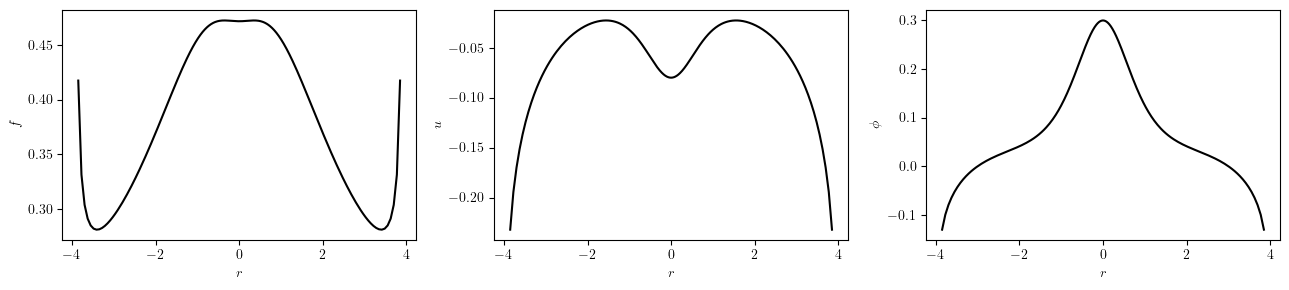

In [33]:
q0, rmax = 1, 5
u0, φ0 = -0.08, 0.3

soln = wh.solve_S3S3(q0, rmax, u0, φ0)
r, f, u, ud, φ, φd, h, flux4 = wh.symmetrize_S3S3(soln)

fig, axes = plt.subplots(1, 3, figsize=(13,3))

for ax, y, label in zip(axes, [f, u, φ], ['$f$', '$u$', '$\phi$']):
    ax.plot(r, y, 'k')
    ax.set_xlabel('$r$')
    ax.set_ylabel(label)

plt.tight_layout()
plt.show()

### Shooting method

Optimal values for $(u_0,\phi_0)$ to match the AdS boundary conditions for $r\to\infty$ are found using a shooting method.

Optimizing (u0, φ0) for (q0, rmax) = (1.0000, 20.0000)
       success : True
        f_eval : 152
            u0 : -0.07891872313
            v0 : +0.2943216214
         value : 0


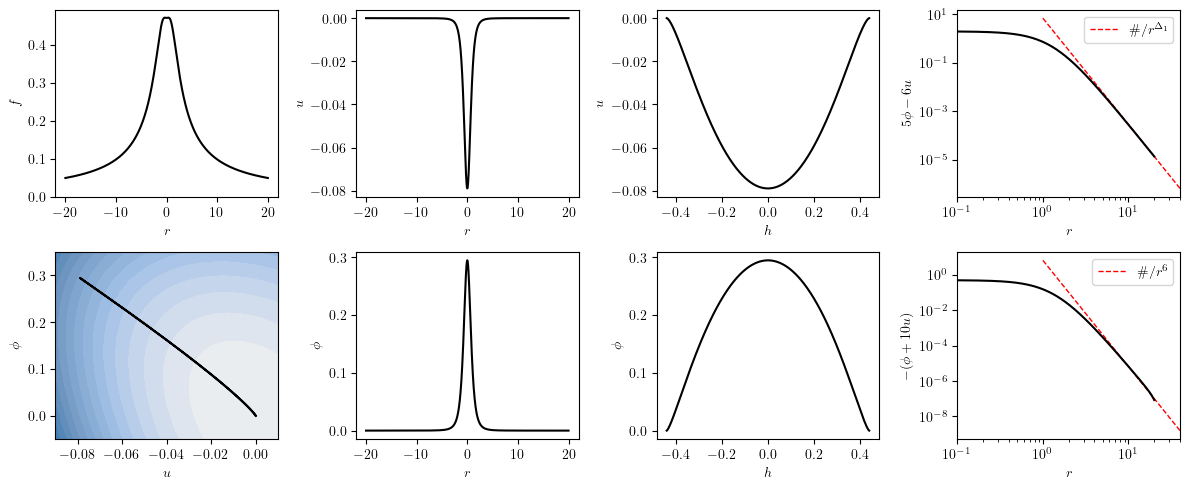

In [49]:
q0, rmax = 1, 20

soln = wh.wormhole_S3S3(q0, rmax, display='summary')
r, f, u, ud, φ, φd, h, f4sqr = soln



fig, axes = plt.subplots(2, 4, figsize=(12,5))

q = wh.Q(r, q0)

xdata = [r, r, h, r, u, r, h, r]
ydata = [f, u, u, 5*φ-6*u, φ, φ, φ, -(φ+10*u)]
xlabels = ['$r$', '$r$', '$h$', '$r$', '$u$', '$r$', '$h$', '$r$']
ylabels = ['$f$', '$u$', '$u$', '$5\phi-6u$', '$\phi$', '$\phi$', '$\phi$', '$-(\phi+10u)$']


# Plot expected power-law fall-offs in asymptotic region
Δ1 = (3+np.sqrt(33))/2
fcoeff = np.mean(r[-10:]**2 * (f[-10:]**(-2) - (r[-10:]**2 + (1+2*q0**2))))
uφcoeff1 = np.mean(r[-10:]**Δ1 * (5*φ[-10:] - 6*u[-10:]))
uφcoeff2 = np.mean(r[-10:]**6 * (-φ[-10:] - 10*u[-10:]))

rr = np.linspace(q0, 2*rmax, 2)
axes[0,3].plot(rr, uφcoeff1/rr**Δ1, '--r', lw=1, label='$\#/r^{\Delta_1}$')
axes[1,3].plot(rr, uφcoeff2/rr**6, '--r', lw=1, label='$\#/r^6$')

# Plot grid of xy-data
for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

axes[0,0].set_ylim(0)

# Superimpose potential in u-φ plot
u0s = np.linspace(-0.09, 0.01, 40)
φ0s = np.linspace(-0.05, 0.35, 40)
umesh, φmesh = np.meshgrid(u0s, φ0s)
VV = wh.V_S3S3(umesh, φmesh)

axes[1,0].contourf(umesh, φmesh, VV,
                   levels=np.arange(-6, -4.4, 0.1),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], φ0s[0], φ0s[-1])
                  )

axes[1,0].set_xlim(u0s[0], u0s[-1])
axes[1,0].set_ylim(φ0s[0], φ0s[-1])


for ax in axes[:,3]:
    ax.set_xlim(0.1*q0, 2*rmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()

# plt.savefig('images/S3S3_profile_example.png', dpi=300)
plt.show()

### Scalar field ranges

Field ranges for $u$ and $\phi$ remain $\mathcal{O}(1)$ for all $q_0$. Below the field ranges are compared to the ranges of the Giddings-Strominger solution which appears when $u$ and $\phi$ are "approximated" to be massless (via the _ad hoc_ replacement $\mathcal{V}\to -6$).

In [71]:
q0s = np.geomspace(0.0001, 100, 20)

q0s_ml = np.geomspace(q0s[0], q0s[-1], 20)
data_ml = np.asarray([wh.massless_approx_S3S3(q0) for q0 in q0s_ml])
u0s_ml, φ0s_ml, flux4s_ml = data_ml.T

data = []

for q0 in q0s:

    rmax = max(10, 10*q0)
    soln = wh.wormhole_S3S3(q0, rmax, display='quiet')
    r, f, u, ud, φ, φd, h, flux4 = soln

    # It happens that u<0 and φ>0
    data.append([min(u), max(φ), flux4])

u0s, φ0s, flux4s = np.asarray(data).T

Optimizing (u0, φ0) for (q0, rmax) = (0.0001, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0002, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0004, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0009, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0018, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0038, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0078, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0162, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0336, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0695, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.1438, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.2976, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.6158, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (1.2743, 12.7427)	DONE: value = 0
Optimi

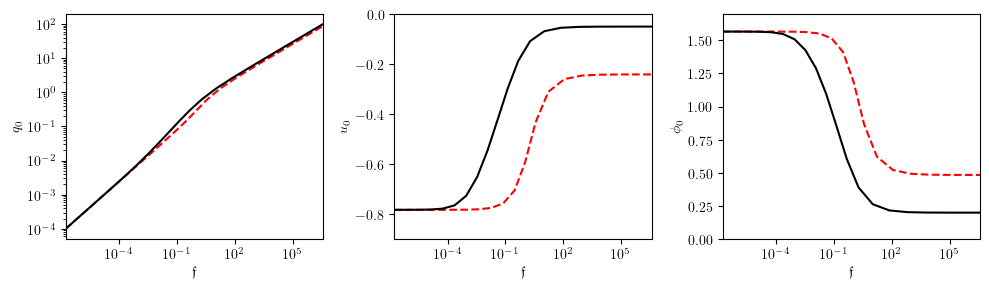

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), sharex=True)

axes[0].plot(flux4s_ml, q0s_ml, '--r')
axes[0].plot(flux4s, q0s, 'k')
axes[0].set_yscale('log')
axes[0].set_ylabel('$q_0$')

axes[1].plot(flux4s_ml, u0s_ml, '--r')
axes[1].plot(flux4s, u0s, 'k')
axes[1].set_ylabel('$u_0$')
axes[1].set_ylim(-0.9, 0)

axes[2].plot(flux4s_ml, φ0s_ml, '--r')
axes[2].plot(flux4s, φ0s, 'k')
axes[2].set_ylabel('$\phi_0$')
axes[2].set_ylim(0, 1.7)

plt.xlim(flux4s[0], flux4s[-1])
plt.xscale('log')
for ax in axes:
    ax.set_xlabel('$\mathfrak{f}$')

plt.tight_layout()
# plt.savefig('images/S3S3_ranges.png', dpi=300)
plt.show()

### Flat-space limit

The flat space limit is $\ell\to\infty$ with $a_0=\ell q_0$ held fixed. The appropriately rescaled radial coordinate and flux are $\ell r$ and $\ell^2\mathfrak{f}$. Notice that the metric only converges point-wise (i.e. not uniformly) since $f\to1$ in the flat-space limit $\ell\to\infty$, while $f\xrightarrow{\ell r\gtrsim\ell}\frac{1}{r}$ for any finite $\ell$.

Optimizing (u0, φ0) for (q0, rmax) = (1.0000, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.1000, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0100, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0010, 10.0000)	DONE: value = 0
Optimizing (u0, φ0) for (q0, rmax) = (0.0001, 10.0000)	DONE: value = 0


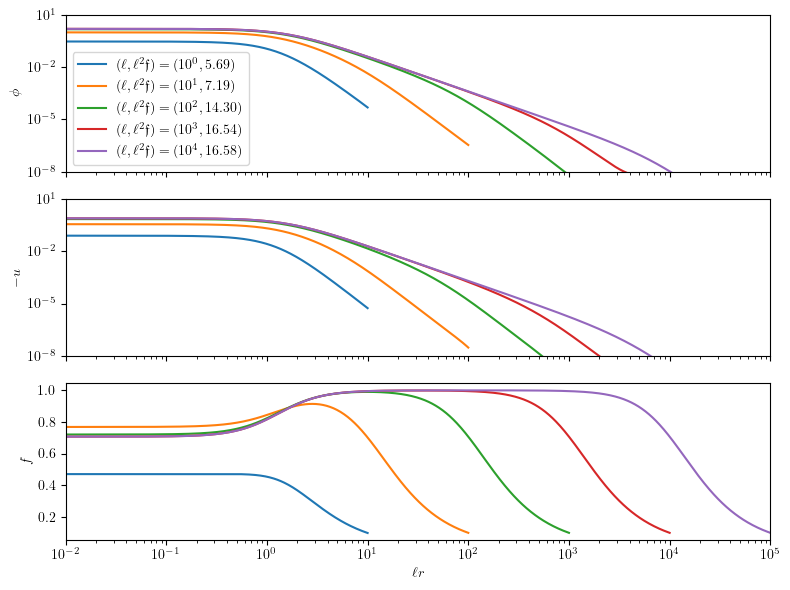

In [87]:
a0 = 1
powers = np.arange(0, 5, 1)

fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

for power in powers:
    l = 10**power
    q0 = a0 / l
    
    rmax = 10
    soln = wh.wormhole_S3S3(q0, rmax, display='quiet')
    r, f, u, ud, φ, φd, h, flux4 = soln

    q = wh.Q(r, q0)

    axes[0].plot(l*r, φ, label='$(\ell,\ell^2\mathfrak f)=(10^{},{:.2f})$'.format(power, flux4*l**2))
    axes[1].plot(l*r, -u)
    axes[2].plot(l*r, f)

plt.xlim(10**-2, 10**5)
plt.xscale('log')
plt.xlabel('$\ell r$')

axes[0].set_ylim(10**-8, 10)
axes[0].set_yscale('log')
axes[0].set_ylabel('$\phi$')
axes[0].legend()

axes[1].set_ylim(10**-8, 10)
axes[1].set_yscale('log')
axes[1].set_ylabel('$-u$')

axes[2].set_ylabel('$f$')

plt.tight_layout()
# plt.savefig('images/S3S3_flat_limit.png', dpi=300)
plt.show()

# Type IIB on $T^{1,1}$

__BACKGROUND__

### Example profiles

Picking $(u_0,v_0)$ by hand typically results in singular solutions. Matching to the AdS boundary conditions requires $f\sim\frac{1}{r}$ and $u,v,\phi',\chi'\to0$.

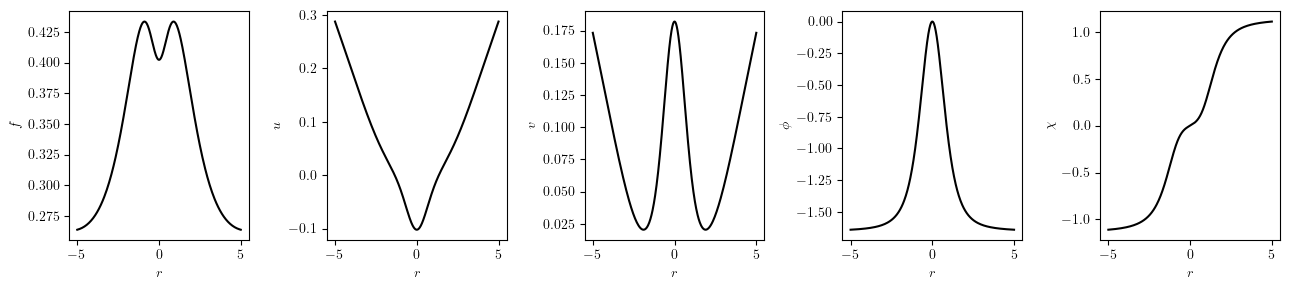

In [18]:
q0, rmax = 1, 5
u0, v0 = -0.102, 0.182
χ1 = 0.1

soln = wh.solve_T11(q0, u0, v0, 0, χ1, rmax)
r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2 = wh.symmetrize_T11(soln)

fig, axes = plt.subplots(1, 5, figsize=(13,3))

for ax, y, label in zip(axes, [f, u, v, φ, χ], ['$f$', '$u$', '$v$', '$\phi$', '$\chi$']):
    ax.plot(r, y, 'k')
    ax.set_xlabel('$r$')
    ax.set_ylabel(label)

plt.tight_layout()
plt.show()

### Shooting method

Optimal values for $(u_0,v_0)$ to match the AdS boundary conditions for $r\to\infty$ are found using a shooting method.

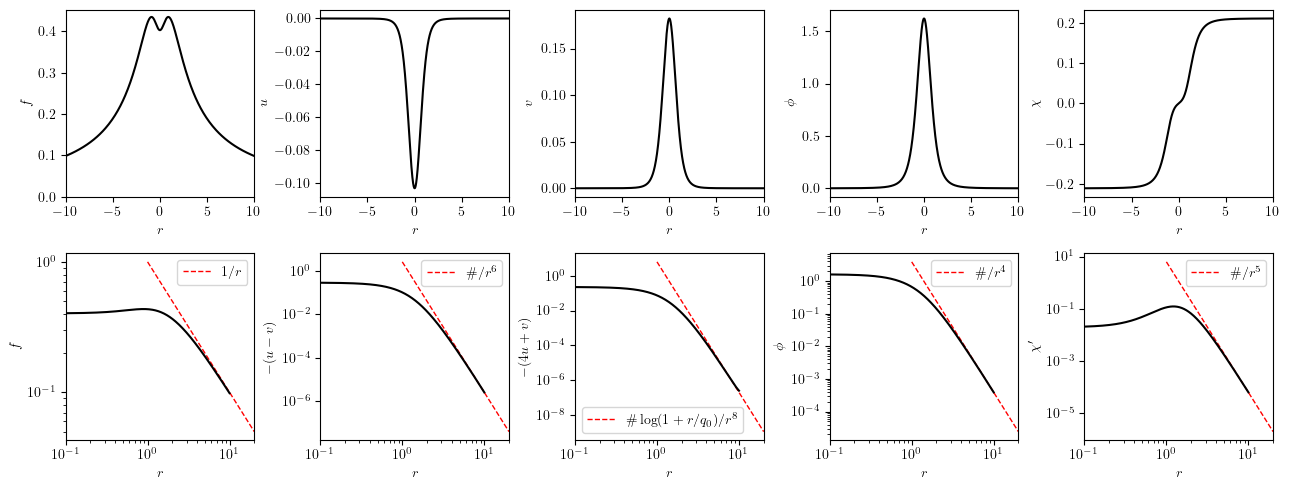

In [72]:
q0 = 1
rmax = 10
χ1 = 0.1

soln = wh.wormhole_T11(q0, χ1, rmax)
r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2 = soln



fig, axes = plt.subplots(2, 5, figsize=(13, 5), sharex='row')

ydata = [f, u, v, φ, χ, f, -(u-v), -(4*u+v), φ, χd]
ylabels = ['$f$', '$u$', '$v$', '$\phi$', '$\chi$', '$f$', '$-(u-v)$', '$-(4u+v)$', '$\phi$', '$\chi\'$']


# Plot expected power-law fall-offs in asymptotic region
uvcoeff1 = np.mean(r[-10:]**6 * (-u[-10:] + v[-10:]))
uvcoeff2 = np.mean(r[-10:]**8 * (-4*u[-10:] - v[-10:]) / np.log(1 + r[-10:]/q0))
φ4 = np.mean(r[-10:]**4 * φ[-10:])
χ4 = np.mean(-0.25 * r[-10:]**5 * χd[-10:])


rr = np.linspace(q0, 2*rmax, 2)
axes[1,0].plot(rr, 1/rr, '--r', lw=1, label='$1/r$')
axes[1,1].plot(rr, uvcoeff1/rr**6, '--r', lw=1, label='$\#/r^6$')
axes[1,2].plot(rr, uvcoeff2 * np.log(1+rr/q0)/rr**8, '--r', lw=1, label='$\#\log(1+r/q_0)/r^8$')
axes[1,3].plot(rr, φ4/rr**4, '--r', lw=1, label='$\#/r^4$')
axes[1,4].plot(rr, -4*χ4/rr**5, '--r', lw=1, label='$\#/r^5$')

# Plot grid of xy-data
for ax, yy, ylab in zip(axes.ravel(), ydata, ylabels):
    ax.plot(r, yy, 'k')
    ax.set_xlabel('$r$')
    ax.set_ylabel(ylab)

axes[0,0].set_ylim(0)

for ax in axes[1]:
    ax.set_yscale('log')
    ax.legend()


axes[0,0].set_xlim(-rmax, rmax)
axes[1,0].set_xlim(0.1*q0, 2*rmax)
axes[1,0].set_xscale('log')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
# plt.savefig('images/T11_profiles_ex1.png', dpi=300)
plt.show()

### Scalar field ranges & BPS bounds

First collect data:

In [35]:
# data = np.empty([11, 0])
data = np.load('T11_data.npy')

In [36]:
# q0_list = np.geomspace(0.01, 10, 3)
q0_list = 10**(3*np.random.rand(3) - 2)

for q0 in q0_list:

    δχ1 = 0.1/max(q0, 2)
    done = False
    χ1 = 0

    while not done:

        rmax = max(20, 20*q0)
        soln, value = wh.wormhole_T11(q0, χ1, rmax, display='quiet')

        if soln is None:
            done = True
            
        else:
            r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2 = soln

            # Get field ranges
            u0 = min(u)
            v0 = max(v)
            φ0 = max(φ)

            # Estimate φ4, χ4 and χinf
            mask = (r > rmax/1.5)
            
            popt, pcov = curve_fit(wh.masslessScalarFit_alt, r[mask]/q0, r[mask]**5 * φd[mask])
            φ4 = popt[0]

            popt, pcov = curve_fit(wh.masslessScalarFit_alt, r[mask]/q0, r[mask]**5 * (φd[mask] + χd[mask]))
            φχ4 = popt[0]
            
            if χ1 == 0:
                χinf, χ4 = 0, 0
            else:
                popt, pcov = curve_fit(wh.masslessScalarFit, r[mask]/q0, χ[mask])
                χinf = popt[0]

                popt, pcov = curve_fit(wh.masslessScalarFit_alt, r[mask]/q0, r[mask]**5 * χd[mask])
                χ4 = popt[0]

            if value < 10**-4:
                data = np.append(data, np.array([[q0, χ1, rmax, u0, v0, φ0, φ4, χ4, φχ4, χinf, flux2]]).T, axis=1)

            χ1 += δχ1

Optimizing (u0, v0) for (q0, χ1, rmax) = (0.2395, 0.0000, 20.0000)	Failed to converge
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.0000, 20.0000)	DONE: value = 2.22e-15
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.0500, 20.0000)	DONE: value = 4.863e-14
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.1000, 20.0000)	DONE: value = 2.143e-13
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.1500, 20.0000)	DONE: value = 5.802e-13
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.2000, 20.0000)	DONE: value = 1.368e-12
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.2500, 20.0000)	DONE: value = 3.144e-12
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.3000, 20.0000)	DONE: value = 7.627e-12
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.3500, 20.0000)	DONE: value = 2.101e-11
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.4000, 20.0000)	DONE: value = 7.363e-11
Optimizing (u0, v0) for (q0, χ1, rmax) = (0.9732, 0.4500, 20.0000)	DONE: value = 4.072e-10
Optim

In [21]:
np.save('T11_data.npy', data)

In [22]:
q0s, χ1s, rmaxes, u0s, v0s, φ0s, φ4s, χ4s, φχ4s, χinfs, flux2s = data

6.263113426986835


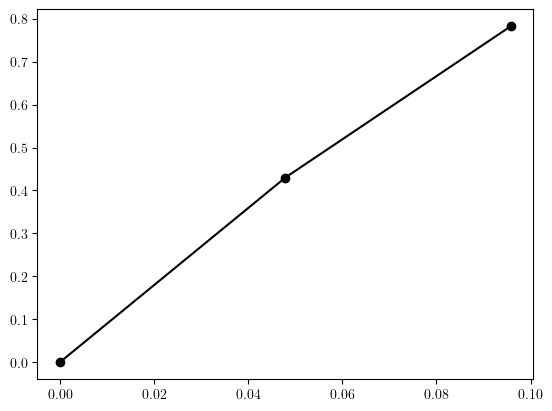

In [34]:
n = 14
print(q0s[n])
mask = (q0s == q0s[n])

plt.plot(χ1s[mask], χinfs[mask], '-ok')

plt.show()

For $\chi=0$ the values of $u_0$, $v_0$, $\phi_0$ and the flux can be compared with the two Giddings-Strominger "approximations".

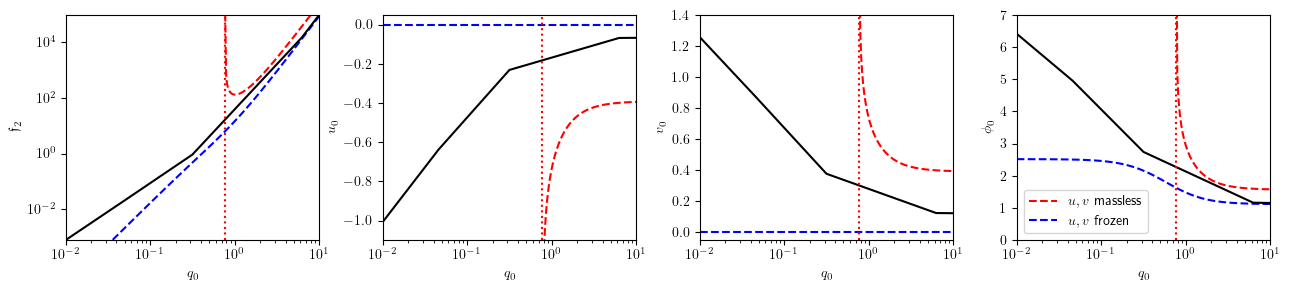

In [26]:
mask = np.where(χinfs == 0)[0]
mask = mask[np.argsort(q0s[mask])]

q0s_ml = np.geomspace(0.7728, max(q0s[mask]), 100)
data_ml = np.asarray([wh.massless_approx_T11(q0) for q0 in q0s_ml])
u0_ml, v0_ml, φ0_ml, flux2_ml = data_ml.T

q0s_fr = np.geomspace(min(q0s[mask]), max(q0s[mask]), 100)
data_fr = np.asarray([wh.frozen_approx_T11(q0) for q0 in q0s_fr])
u0_fr, v0_fr, φ0_fr, flux2_fr = data_fr.T


fig, axes = plt.subplots(1, 4, figsize=(13,3), sharex=True)

axes[0].plot(q0s_ml, flux2_ml, '--r')
axes[0].plot(q0s_fr, flux2_fr, '--b')
axes[0].plot(q0s[mask], flux2s[mask], 'k')

axes[1].plot(q0s_ml, u0_ml, '--r')
axes[1].plot(q0s_fr, u0_fr, '--b')
axes[1].plot(q0s[mask], u0s[mask], 'k')

axes[2].plot(q0s_ml, v0_ml, '--r')
axes[2].plot(q0s_fr, v0_fr, '--b')
axes[2].plot(q0s[mask], v0s[mask], 'k')

axes[3].plot(q0s_ml, φ0_ml, '--r', label='$u,v$ massless')
axes[3].plot(q0s_fr, φ0_fr, '--b', label='$u,v$ frozen')
axes[3].plot(q0s[mask], φ0s[mask], 'k')

for ax, ylab in zip(axes, ['$\mathfrak{f}_2$', '$u_0$', '$v_0$', '$\phi_0$']):
    ax.axvline(q0s_ml[0], ls=':', c='r')
    ax.set_xlabel('$q_0$')
    ax.set_ylabel(ylab)

plt.xlim(min(q0s[mask]), max(q0s[mask]))
plt.xscale('log')

axes[0].set_yscale('log')
axes[0].set_ylim(min(flux2s[mask]), max(flux2s[mask]))
axes[1].set_ylim(-1.1, 0.05)
axes[2].set_ylim(-0.05, 1.4)
axes[3].set_ylim(0, 7)

axes[3].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
# plt.savefig('T11_ranges.png', dpi=300)
plt.show()

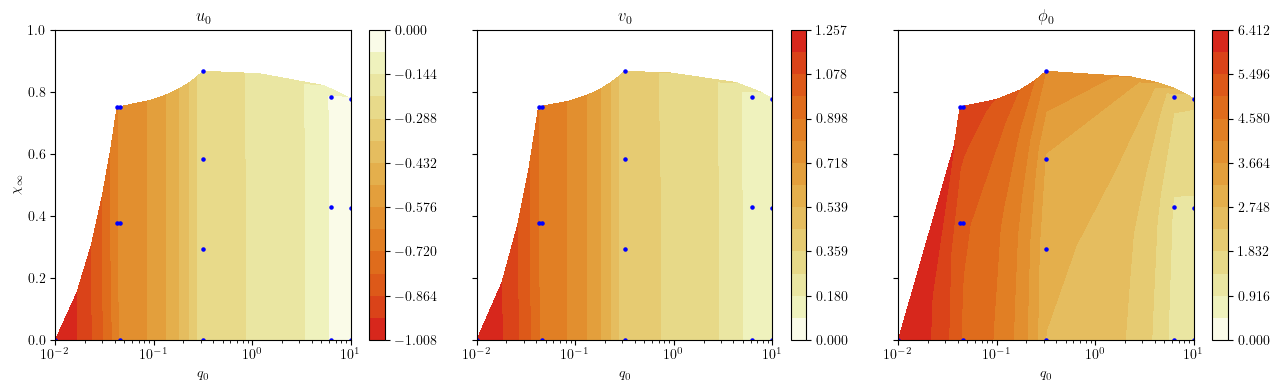

In [24]:
# Perform triangulation on log data
tri = Triangulation(np.log(q0s), χinfs)
# tri = Triangulation(q0s, χinfs)
tri.x = np.exp(tri.x)


fig, axes = plt.subplots(1, 3, figsize=(13,4), sharex=True, sharey=True)

im = axes[0].tricontourf(tri, u0s, levels=np.linspace(min(u0s), 0, 15), cmap=cc.cm['CET_L18_r'])
plt.colorbar(im, ax=axes[0])

im = axes[1].tricontourf(tri, v0s, levels=np.linspace(0, max(v0s), 15), cmap=cc.cm['CET_L18'])
plt.colorbar(im, ax=axes[1])

im = axes[2].tricontourf(tri, φ0s, levels=np.linspace(0, max(φ0s), 15), cmap=cc.cm['CET_L18'])
plt.colorbar(im, ax=axes[2])


for ax, title in zip(axes, ['$u_0$', '$v_0$', '$\phi_0$']):
    ax.scatter(q0s, χinfs, color='b', s=5)
    ax.set_xlabel('$q_0$')
    ax.set_title(title)

axes[0].set_ylabel('$\chi_\infty$')

plt.xscale('log')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

### BPS bounds

In [626]:
bps1 = 4*(φ4s + χ4s)/flux2s - (1 - χinfs)
bps2 = 4*(φ4s + χ4s)/flux2s + (1 - χinfs)

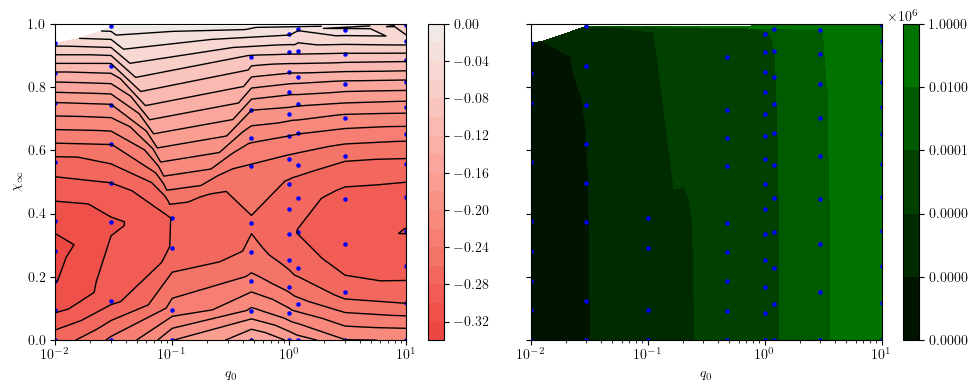

In [627]:
max1 = max(abs(bps1))

# Perform triangulation on log data
tri = Triangulation(np.log(q0s), χinfs)
tri.x = np.exp(tri.x)


fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

im = axes[0].tricontourf(tri, bps1, levels=15, cmap=cc.cm['CET_D3_r'], vmin=-max1, vmax=max1)
axes[0].tricontour(tri, bps1, levels=15, colors='k', linewidths=1, linestyles='solid', vmin=-max1, vmax=max1)
plt.colorbar(im, ax=axes[0])
axes[0].scatter(q0s, χinfs, color='b', s=5)

im = axes[1].tricontourf(tri, flux2s, levels=15, cmap=cc.cm['CET_L14'], norm=colors.LogNorm())
plt.colorbar(im, ax=axes[1])
axes[1].scatter(q0s, χinfs, color='b', s=5)

plt.xscale('log')
axes[0].set_xlabel('$q_0$')
axes[1].set_xlabel('$q_0$')

axes[0].set_ylabel('$\chi_\infty$')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

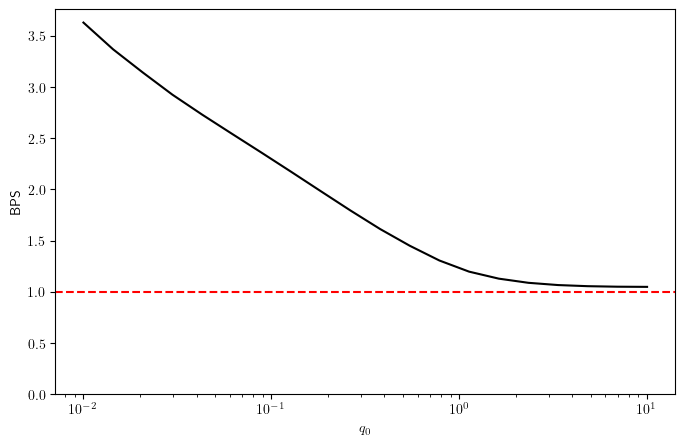

In [103]:
bps = 4*φ4s/flux2s

fig, ax = plt.subplots(1, 1, figsize=(8,5))

plt.axhline(1, ls='--', c='r')
plt.plot(q0s, bps, 'k')

plt.xlabel('$q_0$')
plt.ylabel('BPS')
plt.xscale('log')
plt.ylim(0)

plt.show()